## Rock Paper Scissors Classifier

### Import Libraries

!pip install opendatasets
!pip install pillow
!pip install pandas
!pip install numpy
!pip install tensorflow
!pip install seaborn
!pip install matplotlib

In [1]:
import opendatasets as od
import os
import re
from PIL import Image

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow import keras
import keras_tuner as kt

from keras.applications.vgg16 import VGG16

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

### Download Dataset

In [2]:
def downloadDataSet():
    url  = "https://www.kaggle.com/datasets/glushko/rock-paper-scissors-dataset/download"
    path = "rock-paper-scissors-dataset"
    
    if os.path.exists(path):
        print("File already downloaded")
    else:
        od.download(url)
        print("File successfully downloaded")

In [3]:
downloadDataSet()

File already downloaded


### Load Dataset

In [4]:
img_height = 150
img_width  = 150
batch_size = 32

def loadDataSet():
    path_train = "rock-paper-scissors-dataset/train"
    path_val   = "rock-paper-scissors-dataset/val"
    path_test  = "rock-paper-scissors-dataset/test"
    return image_dataset_from_directory(path_train, batch_size=batch_size, image_size=(img_height, img_width)), image_dataset_from_directory(path_val, image_size=(img_height, img_width)), image_dataset_from_directory(path_test, image_size=(img_height, img_width))
    

In [5]:
train_DS, val_DS, test_DS = loadDataSet()

Found 1020 files belonging to 3 classes.
Found 804 files belonging to 3 classes.
Found 540 files belonging to 3 classes.


In [6]:
class_names = train_DS.class_names
print(class_names)

['paper', 'rock', 'scissors']


### DataVisualization

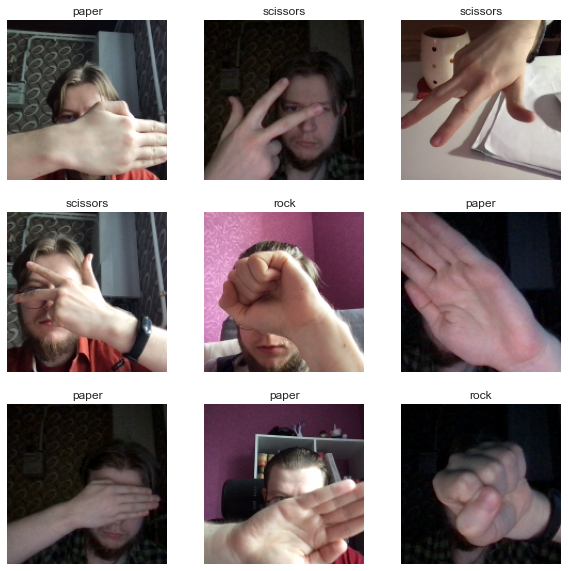

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_DS.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
def plotClassDistribution():
    path = "rock-paper-scissors-dataset"
    class_path = {
        'Rock_train'     : len(os.listdir(os.path.join(path, "train/rock"))),
        'Rock_val'       : len(os.listdir(os.path.join(path, "val/rock"))),
        'Paper_train'    : len(os.listdir(os.path.join(path, "train/paper"))),
        'Paper_val'      : len(os.listdir(os.path.join(path, "val/paper"))),
        'Scissors_train' : len(os.listdir(os.path.join(path, "train/scissors"))),
        'Scissors_val'   : len(os.listdir(os.path.join(path, "val/scissors"))),
    }

    keys = list(class_path.keys())
    values = list(class_path.values())

    ax = sns.barplot(x=keys, y=values)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    plt.tight_layout()
    plt.show()

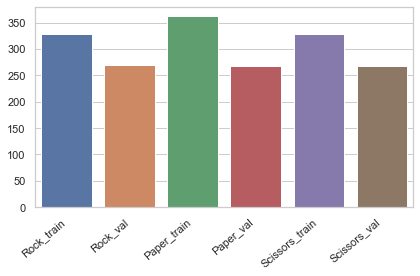

In [9]:
plotClassDistribution()

In [10]:
def plotPieClassDistribution():
    
    
    path = "rock-paper-scissors-dataset"
    class_path = {
        'Rock'     : len(os.listdir(os.path.join(path, "train/rock"))) + len(os.listdir(os.path.join(path, "val/rock"))),
        'Paper'    : len(os.listdir(os.path.join(path, "train/paper"))) + len(os.listdir(os.path.join(path, "val/paper"))),
        'Scissors' : len(os.listdir(os.path.join(path, "train/scissors"))) + len(os.listdir(os.path.join(path, "val/scissors"))),
    }

    keys = list(class_path.keys())
    values = list(class_path.values())
    plt.pie(values,
            explode=(0, 0, 0) , 
            labels=keys,
            autopct='%1.1f%%')
    plt.axis('equal')
    plt.title('Proportion of each observed category')
    plt.show()

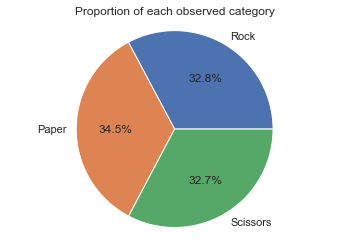

In [11]:
plotPieClassDistribution()

### Modelling

#### Define Model

In [ ]:
model_simple = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(3, activation=tf.nn.softmax)
])

In [ ]:
model_simple2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    #tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    #tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(3, activation=tf.nn.softmax)
])

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model_simple2.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_simple2.summary()

#### Train Modell

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_DS = train_DS.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_DS = val_DS.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
keras.backend.clear_session()

In [ ]:
history = model_simple2.fit(train_DS, validation_data=val_DS, batch_size=batch_size, epochs=10)

In [19]:
def model_builder(hp):
    filters_conv1 = hp.Int('filters_conv1', min_value = 16, max_value=64, step=8, default=32)
    filters_conv2 = hp.Int('filters_conv2', min_value = 16, max_value=64, step=8, default=32)
    bias_conv1 = hp.Boolean('bias_conv1', default=True)
    bias_conv2 = hp.Boolean('bias_conv2', default=True)
    bias_dens1 = hp.Boolean('bias_dens1', default=True)
    units_dens1 = hp.Int('units', min_value = 32, max_value = 512, step = 32)
    learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])
    activation_conv1 = hp.Choice('activation_conv1', values = ['softmax', 'softplus', 'softsign', 'relu', 'selu', 'elu', 'tanh','sigmoid', 'linear'])
    activation_conv2 = hp.Choice('activation_conv2', values = ['softmax', 'softplus', 'softsign', 'relu', 'selu', 'elu', 'tanh','sigmoid', 'linear'])
    activation_dens1 = hp.Choice('activation_dens1', values = ['softmax', 'softplus', 'softsign', 'relu', 'selu', 'elu', 'tanh','sigmoid', 'linear'])

    model_tune = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters_conv1, 
                               (3, 3), 
                               activation = activation_conv1, 
                               use_bias = bias_conv1,
                               input_shape = (150, 150, 3)), 
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(filters_conv2, 
                               (3, 3), 
                               use_bias = bias_conv2,
                               activation = activation_conv2),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units_dens1, 
                              use_bias = bias_dens1,
                              activation=activation_dens1),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    model_tune.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate), 
                       loss = 'sparse_categorical_crossentropy', 
                       metrics=['accuracy'])
    return model_tune


In [22]:

tuner_hb = kt.Hyperband(
    model_builder,
    objective='val_accuracy',
    max_epochs=30,
    hyperband_iterations=1, 
    overwrite=True)

In [23]:

tuner_hb.search(train_DS,
             validation_data=val_DS,
             epochs=30,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])

Trial 90 Complete [00h 00m 42s]
val_accuracy: 0.33457711338996887

Best val_accuracy So Far: 0.5223880410194397
Total elapsed time: 00h 56m 53s
INFO:tensorflow:Oracle triggered exit


In [24]:
tuner_rs = kt.RandomSearch(
    model_builder, 
    objective = 'val_accuracy', 
    max_trials = 30, 
    overwrite=True) 

In [25]:

tuner_rs.search(train_DS,
             validation_data=val_DS,
             epochs=30,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])

Trial 30 Complete [00h 00m 31s]
val_accuracy: 0.3333333432674408

Best val_accuracy So Far: 0.49751242995262146
Total elapsed time: 00h 36m 27s
INFO:tensorflow:Oracle triggered exit


In [26]:
tuner_bo = kt.BayesianOptimization(
    model_builder, 
    objective = 'val_accuracy', 
    max_trials = 30, 
    overwrite=True) 

In [27]:

tuner_bo.search(train_DS,
             validation_data=val_DS,
             epochs=30,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])

Trial 30 Complete [00h 00m 17s]
val_accuracy: 0.3980099558830261

Best val_accuracy So Far: 0.48009949922561646
Total elapsed time: 00h 12m 29s
INFO:tensorflow:Oracle triggered exit


In [ ]:
#best_model = tuner.get_best_models(1)[0]

In [ ]:
#best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

In [ ]:
#tuner.search_space_summary()

In [28]:
tuner_hb.results_summary(1)

Results summary
Results in .\untitled_project
Showing 1 best trials
Trial summary
Hyperparameters:
filters_conv1: 40
filters_conv2: 16
bias_conv1: True
bias_conv2: True
bias_dens1: True
units: 416
learning_rate: 0.0001
activation_conv1: softsign
activation_conv2: elu
activation_dens1: sigmoid
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.5223880410194397


In [29]:
tuner_rs.results_summary(1)

Results summary
Results in .\untitled_project
Showing 1 best trials
Trial summary
Hyperparameters:
filters_conv1: 32
filters_conv2: 40
bias_conv1: True
bias_conv2: False
bias_dens1: False
units: 320
learning_rate: 0.001
activation_conv1: selu
activation_conv2: elu
activation_dens1: softplus
Score: 0.49751242995262146


In [30]:
tuner_bo.results_summary(1)

Results summary
Results in .\untitled_project
Showing 1 best trials
Trial summary
Hyperparameters:
filters_conv1: 16
filters_conv2: 16
bias_conv1: False
bias_conv2: False
bias_dens1: True
units: 416
learning_rate: 0.0001
activation_conv1: linear
activation_conv2: linear
activation_dens1: linear
Score: 0.48009949922561646
